In [5]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np

from sklearn.metrics import recall_score, confusion_matrix
from scripts.functions import create_model

from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, Activation
import matplotlib.pylab as plt
import seaborn as sns

In [6]:
# Create new variables to be used in Keras and the CNN

# number of items to use for training
BATCH_SIZE = 400 

# Number of identifying classes 
#   WE have two, Bloom and no bloom 1/0
NUM_CLASSES = 2 

# number of times to repeat process
EPOCHS = 100

In [7]:
# Load the data
df = pd.read_csv('../../data/cleaned/site1_vineyard.csv')
df.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4


In [8]:
target = df['BGA-Phycocyanin RFU'].apply(lambda x : x/0.2334)
dataset = df.drop(columns=['Chlorophyll (ug/L)', 'Chlorophyll RFU'])
dataset['BGA (ug/L)'] = target
dataset.head(5)

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,BGA (ug/L)
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,1.713796
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,1.713796
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,1.713796
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,1.713796
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,1.713796


In [9]:
from datetime import datetime

timestamp = dataset['Date (mm.dd.yyyy)'] + ' '+ dataset['Time 24hr']
timestamp = pd.to_datetime(timestamp)
dataset['Timestamp'] = timestamp
dataset.head()
#converts the date object to a numerical representation of that object
#dataset['date (mm.dd.yyyy)'] = (dataset['date (mm.dd.yyyy)'] - dataset['date (mm.dd.yyyy)'].min()) / np.timedelta64(1,'D')
#dataset.dtypes

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,BGA (ug/L),Timestamp
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,1.713796,2017-05-05 00:00:00
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,1.713796,2017-05-05 00:15:00
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,1.713796,2017-05-05 00:30:00
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,1.713796,2017-05-05 00:45:00
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,1.713796,2017-05-05 01:00:00


In [10]:
# dont need data and time now that we have Timestamp. Lets remove them

dataset = dataset.drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
dataset.head(10)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,BGA (ug/L),Timestamp
0,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,1.713796,2017-05-05 00:00:00
1,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,1.713796,2017-05-05 00:15:00
2,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,1.713796,2017-05-05 00:30:00
3,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,1.713796,2017-05-05 00:45:00
4,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,1.713796,2017-05-05 01:00:00
5,14.92,1850,-100.1,8.36,16.43,89.8,9.02,0.4,1.713796,2017-05-05 01:15:00
6,14.90,1851,-100.1,8.36,16.35,89.7,9.01,0.4,1.713796,2017-05-05 01:30:00
7,14.88,1852,-100.0,8.36,16.40,89.6,9.00,0.4,1.713796,2017-05-05 01:45:00
8,14.84,1850,-99.9,8.36,16.82,89.4,8.99,0.4,1.713796,2017-05-05 02:00:00
9,14.83,1851,-100.0,8.36,16.50,89.4,8.99,0.4,1.713796,2017-05-05 02:15:00


In [11]:
# lets try to normalize this now....
from sklearn.preprocessing import MinMaxScaler
dataset_columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)', 'ODOSat%','ODO (mg/L)']
scaler = MinMaxScaler()
ds_scaled = scaler.fit_transform(dataset[dataset_columns])
dataset = pd.DataFrame(ds_scaled,columns=dataset_columns)
dataset['BGA (ug/L)'] = target
dataset.describe()

C:\Users\mcneelypj\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA (ug/L)
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,0.560516,0.893366,0.477889,0.541089,0.090355,0.165126,0.273546,4.196706
std,0.267413,0.070246,0.116241,0.113254,0.085879,0.093899,0.116220,3.133775
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.308195,0.853771,0.426166,0.461538,0.045893,0.117086,0.190000,2.142245
50%,0.640366,0.895882,0.492228,0.553846,0.065216,0.138870,0.264545,3.856041
75%,0.784656,0.956502,0.538860,0.592308,0.102407,0.177672,0.370909,5.141388
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,68.980291


In [12]:
target = dataset['BGA (ug/L)']

In [13]:
'''
determines the window size for the daata set
@param dataset - The dataset to get windows for
@param window_size - the size of the window  
@param shift - the amout to shift the window
'''
def windows(dataset, window_size, shift):
    start = 0
    while start+window_size < dataset.shape[0]: 
        yield (int(start), int(start+window_size))
        # shift the window shift blocks of time
        start += shift
        if start % 300 == 0:
            print('Window Segmentation {0:.2f}% done'.format(((start+window_size) / dataset.shape[0]) * 100 ))


'''

Segments the dataset based on the parameters that are passed in.
@param dataset - the dataset to segment into window
@param columns - the array of columns from the dataset to be looked at
@param window_size - the size of the window you would like to be looked at. Defualt is 10

'''
def segment_dataset(dataset, columns, target, window_size=10):    
    print('WINDOW SIZE',window_size)
    print('NUMBER OF COULUMNS',len(columns))
    segments = np.empty((0, window_size, len(columns)))
    labels = np.empty((0))
    count = 0
    for (start, end) in windows(dataset, window_size, 1):
        count+=1
        values = dataset[columns][start:end]
        if(values.shape[0] == window_size):
            segments = np.vstack([segments, np.stack([values])])
            # Takes the larger of the two variables if there are more than one. 
            # This makes it more likly to predict a bloom. Can be changed to iloc[0] to
            # be less likly to predict a bloom (more 0s in the label array)
            
            labels = np.append(labels, dataset[target][start:end].mode().iloc[-1])
        else:
            print("No more Windows available... Exiting")
            break
    return (segments, labels)

In [14]:
(segments, labels) = segment_dataset(dataset, dataset_columns, 'BGA (ug/L)', 9)
print('done')

WINDOW SIZE 9
NUMBER OF COULUMNS 7
Window Segmentation 1.63% done
Window Segmentation 3.21% done
Window Segmentation 4.80% done
Window Segmentation 6.38% done
Window Segmentation 7.96% done
Window Segmentation 9.55% done
Window Segmentation 11.13% done
Window Segmentation 12.71% done
Window Segmentation 14.30% done
Window Segmentation 15.88% done
Window Segmentation 17.46% done
Window Segmentation 19.05% done
Window Segmentation 20.63% done
Window Segmentation 22.21% done
Window Segmentation 23.80% done
Window Segmentation 25.38% done
Window Segmentation 26.96% done
Window Segmentation 28.55% done
Window Segmentation 30.13% done
Window Segmentation 31.71% done
Window Segmentation 33.30% done
Window Segmentation 34.88% done
Window Segmentation 36.46% done
Window Segmentation 38.05% done
Window Segmentation 39.63% done
Window Segmentation 41.21% done
Window Segmentation 42.80% done
Window Segmentation 44.38% done
Window Segmentation 45.97% done
Window Segmentation 47.55% done
Window Segm

In [15]:
segments.shape

(18938, 9, 7)

In [16]:
labels.shape

(18938,)

In [17]:
labels

array([1.71379606, 1.71379606, 1.71379606, ..., 5.14138817, 5.14138817,
       5.14138817])

## Shaping the data to be used in the model.

In [18]:
segments = segments.reshape(len(segments),9,7,1)
segments.shape

(18938, 9, 7, 1)

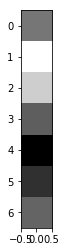

In [19]:
plt.imshow(segments[0][0] * 255, cmap='gray')

## Breaking apart training and test data

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(segments, labels, test_size=0.25)

In [21]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)
input_shape = (9,7,1)


x_train shape: (14203, 9, 7, 1)
x_test shape: (4735, 9, 7, 1)
y_train shape: (14203,)
y_test shape: (4735,)


In [22]:
import datetime
import time
from keras.layers import Dense, Dropout, Conv2D, Flatten, Activation, MaxPooling2D

# Gets the precision of the different metrics
def create_class_predictions(pred):
    retval = np.array([])
    for row in pred:
        max_value = (-1,-1)
        for index, value in enumerate(row):
            if value > max_value[1]:
                max_value = (index, value)
        retval = np.append(retval, max_value[0])
    return retval

## Build the model

In [ ]:
model = Sequential()
model.add(Conv2D(44, 7, input_shape=input_shape, activation='relu', padding='same'))
model.add(Conv2D(44,7, activation='relu', padding='same'))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(44))
model.add(Dropout(0.2))
model.add(Dense(1,activation='softmax'))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop(),
              metrics=['accuracy'])
model.summary()
model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)
# What is our score?
score = model.evaluate(x_train, y_train, verbose=1)
print("Loss {} Accuracy {}".format(score[0], score[1]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 9, 7, 44)          2200      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 9, 7, 44)          94908     
_________________________________________________________________
flatten_14 (Flatten)         (None, 2772)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 2772)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 44)                122012    
_________________________________________________________________
dropout_21 (Dropout)         (None, 44)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 45        
Total para